In [1]:
#1 main objective is to estimate total cases per country on a autmated report

In [2]:
#Dependencies 
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import os
import json
from pandas.io.json import json_normalize
import statsmodels.api as sm

import seaborn as sns 
import datetime as dt
from pptx import Presentation
from pptx.util import Inches, Pt
import os
import folium
from folium.plugins import HeatMap, HeatMapWithTime
import datetime as dt
dt_string = dt.datetime.now().strftime("%d/%m/%Y")
print(f"Kernel last updated: {dt_string}")

Kernel last updated: 06/04/2020


In [3]:
#API getting Global casesper hour 
url = "https://coronavirus-monitor.p.rapidapi.com/coronavirus/worldstat.php"

headers = {
    'x-rapidapi-host': "coronavirus-monitor.p.rapidapi.com",
    'x-rapidapi-key': "bd7544b53amsh2a0b472cd21573bp109cdcjsnb2a1090a7ffd"
    }

response = requests.request("GET", url, headers=headers)

gs = response.json()
print (type(gs))
# print ("initial dictionary = ", gs)
result = json.dumps(gs) 

# transform to dataframe

# printing result as string 
print ("\n", type(result)) 
print ("Api Global Figures = ", result) 

<class 'dict'>

 <class 'str'>
Api Global Figures =  {"total_cases": "1,330,492", "total_deaths": "73,872", "total_recovered": "277,707", "new_cases": "57,630", "new_deaths": "4,447", "statistic_taken_at": "2020-04-06 19:32:09"}


In [4]:
#API getting cases per country daily  
url = "https://coronavirus-monitor.p.rapidapi.com/coronavirus/cases_by_country.php"

# querystring = {"country":"Portugal"}

headers = {
    'x-rapidapi-host': "coronavirus-monitor.p.rapidapi.com",
    'x-rapidapi-key': "bd7544b53amsh2a0b472cd21573bp109cdcjsnb2a1090a7ffd"
    }

response = requests.request("GET", url, headers=headers)

print(response.json())

{'countries_stat': [{'country_name': 'USA', 'cases': '356,653', 'deaths': '10,516', 'region': '', 'total_recovered': '19,308', 'new_deaths': '900', 'new_cases': '19,980', 'serious_critical': '8,876', 'active_cases': '326,829', 'total_cases_per_1m_population': '1,077'}, {'country_name': 'Spain', 'cases': '135,032', 'deaths': '13,169', 'region': '', 'total_recovered': '40,437', 'new_deaths': '528', 'new_cases': '3,386', 'serious_critical': '6,931', 'active_cases': '81,426', 'total_cases_per_1m_population': '2,888'}, {'country_name': 'Italy', 'cases': '132,547', 'deaths': '16,523', 'region': '', 'total_recovered': '22,837', 'new_deaths': '636', 'new_cases': '3,599', 'serious_critical': '3,898', 'active_cases': '93,187', 'total_cases_per_1m_population': '2,192'}, {'country_name': 'Germany', 'cases': '101,779', 'deaths': '1,664', 'region': '', 'total_recovered': '28,700', 'new_deaths': '80', 'new_cases': '1,656', 'serious_critical': '3,936', 'active_cases': '71,415', 'total_cases_per_1m_pop

In [5]:
# from pandas.io.json import json_normalize
new2 = pd.DataFrame(response.json())

#data cleaning
dfglobal=json_normalize(new2['countries_stat'])
dfglobal= dfglobal[['cases','country_name','deaths']]
dfglobal = dfglobal.rename(columns={'cases': 'Cases', 'country_name': 'Country/Region', 'deaths': 'Deaths'})
dfglobal = dfglobal.replace(',','', regex=True)
dfglobal["Cases"] = pd.to_numeric(dfglobal["Cases"])
dfglobal["Deaths"] = pd.to_numeric(dfglobal["Deaths"])
# dfglobal.colums = ['Index','cases', 'Country/Region', 'deaths']
dfglobal.head(5)

,Cases,Country/Region,Deaths
0,356653,USA,10516
1,135032,Spain,13169
2,132547,Italy,16523
3,101779,Germany,1664
4,98010,France,8911


In [6]:
#getting latitude and longitude per country 
dfgeodata = pd.read_csv ('geodata.csv')  
dfgeodata.head(5)

,latitude,longitude,Country/Region
0,42.546245,1.601554,Andorra
1,23.424076,53.847818,United Arab Emirates
2,33.939110,67.709953,Afghanistan
3,17.060816,-61.796428,Antigua and Barbuda
4,18.220554,-63.068615,Anguilla


In [7]:
#merging geodata with global API 
dfglobal_geo = dfglobal.merge(dfgeodata,on='Country/Region')
dfglobal_geo = dfglobal_geo.sort_values(['Cases'], ascending=[False]).reset_index(drop=True)

df = dfglobal_geo
dfglobal_geo.head(5)

,Cases,Country/Region,Deaths,latitude,longitude
0,356653,USA,10516,37.090240,-95.712891
1,135032,Spain,13169,40.463667,-3.749220
2,132547,Italy,16523,41.871940,12.567380
3,101779,Germany,1664,51.165691,10.451526
4,98010,France,8911,46.227638,2.213749


In [8]:
#Creating a a heat map of cases
m = folium.Map()
#Setting up the world countries data URL
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json'

m = folium.Map(location=[42.546245, 1.601554], zoom_start=4)

m.choropleth(
    #The GeoJSON data to represent the world country
    geo_data=country_shapes,
    name='choropleth COVID-19',
    data=dfglobal_geo,
    #The column aceppting list with 2 value; The country name and  the numerical value
    columns=['Country/Region', 'Cases'],
    key_on='feature.properties.name',
    fill_color='PuRd',
#     nan_fill_color='white'
)
folium.LayerControl().add_to(m)

m

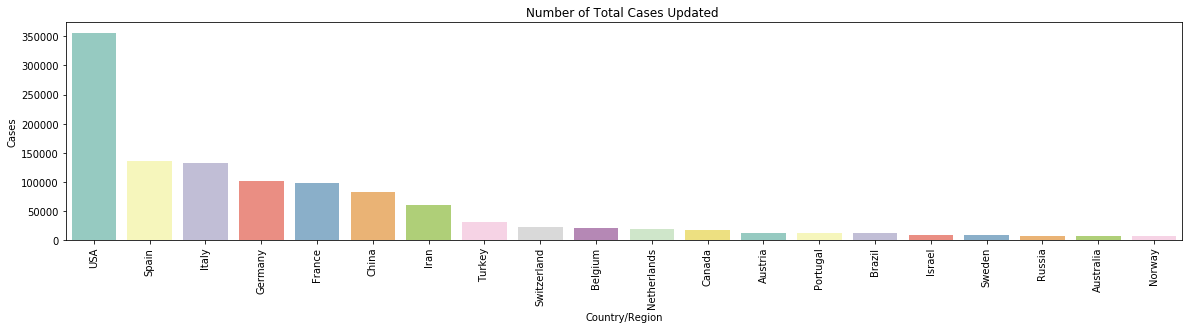

In [9]:
#plotting graph
def plot_count(feature, value, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    df = dfglobal_geo
    g = sns.barplot(df[feature][0:20], df[value][0:20], palette='Set3')
    g.set_title("Number of {} ".format(title))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
#     plt.savefig("pic1.png", dpi=150)
    plt.show()

plot_count('Country/Region', 'Cases', 'Total Cases Updated', 'Total', size=5)


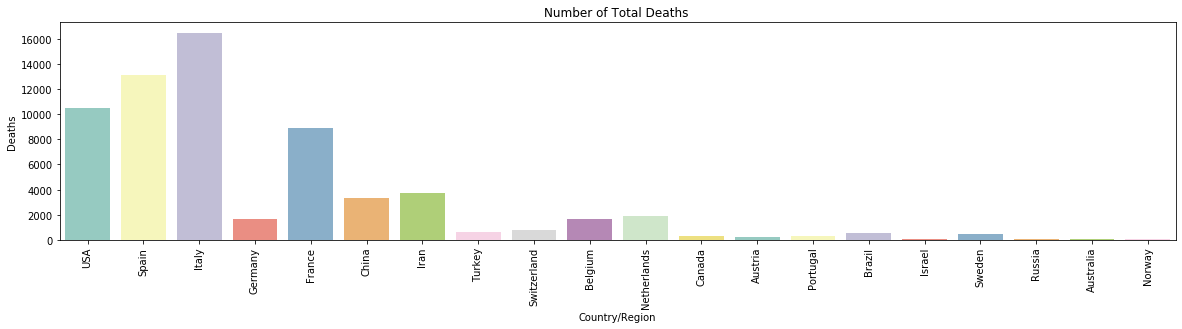

In [10]:

plot_count('Country/Region', 'Deaths', 'Total Deaths', 'Total', size=5)

In [11]:
url="https://covid.ourworldindata.org/data/ecdc/total_cases.csv"
dftotal=pd.read_csv(url)

dftotal.rename(columns={'United States': 'USA'}, inplace=True)

dftotal_ww = dftotal.drop(['World'], axis=1)
# dftotal_ww.head(10) - df without World

dfplot = dftotal_ww[['date', 'USA','Italy', 'Spain','Portugal','Iran','France','China', 'South Korea']]
dfplot=dfplot.tail(100)
dfplot.head()

,date,USA,Italy,Spain,Portugal,Iran,France,China,South Korea
0,2019-12-31,0,0,0,NaN,0,0,27,0
1,2020-01-01,0,0,0,NaN,0,0,27,0
2,2020-01-02,0,0,0,NaN,0,0,27,0
3,2020-01-03,0,0,0,NaN,0,0,44,0
4,2020-01-04,0,0,0,NaN,0,0,44,0


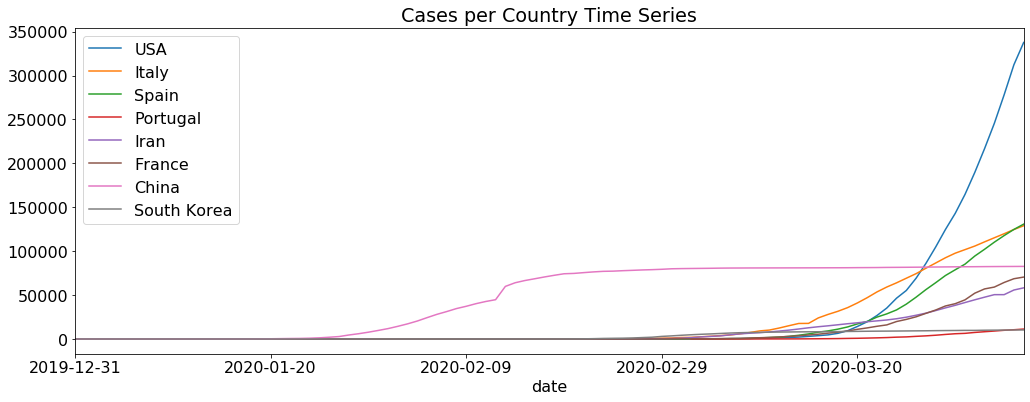

In [12]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (17,6)
plt.rcParams.update({'font.size': 16})
# plt.savefig('pic3.png', dpi=150)
# plt.title('Cases per Country Time Series')
# plt.xlabel('Cases tested')
# plt.ylabel('Date')
dfplot.plot(title='Cases per Country Time Series', x='date', y=['USA', 'Italy', 'Spain', 'Portugal','Iran', 'France', 'China', 'South Korea'])
plt.show()

In [13]:
#per country search last update
url = "https://coronavirus-monitor.p.rapidapi.com/coronavirus/cases_by_particular_country.php"

querystring = {"country":"Portugal"}

headers = {
    'x-rapidapi-host': "coronavirus-monitor.p.rapidapi.com",
    'x-rapidapi-key': "bd7544b53amsh2a0b472cd21573bp109cdcjsnb2a1090a7ffd"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.json())


{'country': 'Portugal', 'stat_by_country': [{'id': '352', 'country_name': 'Portugal', 'total_cases': '448', 'new_cases': '117', 'active_cases': '444', 'total_deaths': '1', 'new_deaths': '', 'total_recovered': '3', 'serious_critical': '18', 'region': None, 'total_cases_per1m': '43.9', 'record_date': '2020-03-17 21:00:05.485'}, {'id': '517', 'country_name': 'Portugal', 'total_cases': '448', 'new_cases': '117', 'active_cases': '444', 'total_deaths': '1', 'new_deaths': '', 'total_recovered': '3', 'serious_critical': '18', 'region': None, 'total_cases_per1m': '43.9', 'record_date': '2020-03-17 21:10:02.648'}, {'id': '682', 'country_name': 'Portugal', 'total_cases': '448', 'new_cases': '117', 'active_cases': '444', 'total_deaths': '1', 'new_deaths': '', 'total_recovered': '3', 'serious_critical': '18', 'region': None, 'total_cases_per1m': '43.9', 'record_date': '2020-03-17 21:20:01.595'}, {'id': '847', 'country_name': 'Portugal', 'total_cases': '448', 'new_cases': '117', 'active_cases': '444

In [14]:
#Get last data per input country 
from pandas.io.json import json_normalize

#first try
new = pd.DataFrame(response.json())

#second try
dfinputcountry=json_normalize(new['stat_by_country'])
dfinputcountry.tail()
df2 = dfinputcountry.iloc[[-1,]]
df2


,active_cases,country_name,id,new_cases,new_deaths,record_date,region,serious_critical,total_cases,total_cases_per1m,total_deaths,total_recovered
2675,"11,279",Portugal,525587,452,16,2020-04-06 19:30:01.335,None,270,"11,730","1,150",311,140


In [15]:
#Portugal Analysis 
dftotal_Portugal = dftotal[['date','Portugal']]
dftotal_Portugal =dftotal_Portugal.dropna()
dftotal_Portugal.head()

,date,Portugal
63,2020-03-03,2.0
64,2020-03-04,4.0
65,2020-03-05,5.0
66,2020-03-06,9.0
67,2020-03-07,13.0


In [16]:
#analysis based on Tested Per Million People (TMP)
dfanalisis = pd.read_csv ('analisis.csv')
# dfanalisis=dfanalisis.dropna()
dfitaly = dfanalisis[['date','Italy']]
dfanalisis.tail() 

,date,Italy,SK,USA,Italy-TMP,SK-TMP,USA-TMP
68,28-Mar,86498,9478,104686,7263.841401,7531.504228,2219.776710
69,29-Mar,92472,9583,124665,7678.235803,7652.186913,2508.364216
70,30-Mar,97689,9661,143025,8072.759431,7672.630746,2850.827103
71,31-Mar,101739,9786,164620,8573.486000,7971.036932,3164.970416
72,01-Apr,105792,9786,189618,9156.164709,8184.270189,3469.675882


In [17]:
# dfanalysis_plot = dfanalisis
# dfanalysis_plot['Italy'] = dfanalysis_plot['Italy']
# dfanalysis_plot.tail()

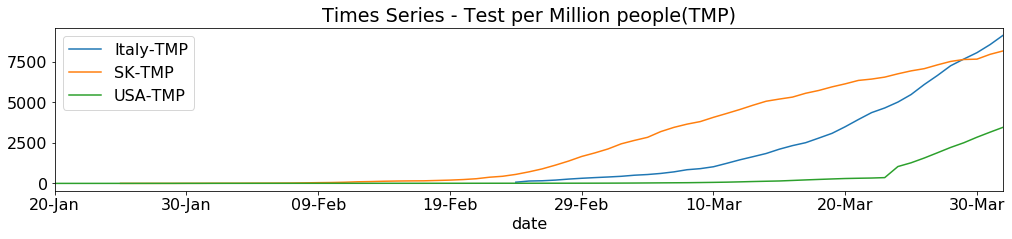

In [18]:
plt.rcParams["figure.figsize"] = (17,3)
plt.rcParams.update({'font.size': 16})
# plt.savefig("pic4.png", dpi=150)
dfanalisis.plot(title='Times Series - Test per Million people(TMP)', x="date", y=['Italy-TMP', 'SK-TMP', 'USA-TMP'])
plt.show()

In [19]:
df = dfitaly
df = df.replace(0, np.nan)
df = df.dropna().reset_index()
dfitaly = df
#dfitaly[dfitaly['Italy'] > 3]
dfitaly.head()


,index,date,Italy
0,11,31-Jan,3.0
1,12,01-Feb,3.0
2,13,02-Feb,3.0
3,14,03-Feb,3.0
4,15,04-Feb,3.0


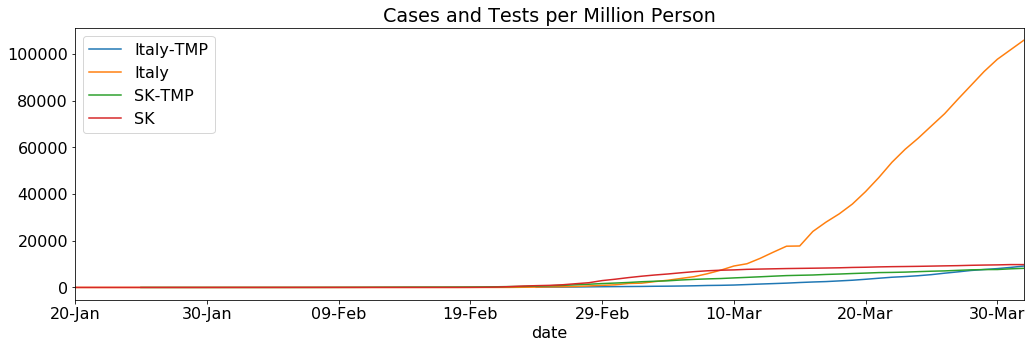

In [20]:
plt.rcParams["figure.figsize"] = (17,5)
plt.rcParams.update({'font.size': 16})
# plt.savefig("pic5.png", dpi=150)
dfanalisis.plot(title = "Cases and Tests per Million Person", x="date", y=['Italy-TMP', 'Italy', 'SK-TMP', 'SK'])
plt.show()

In [21]:
dfitaly = dfitaly[dfitaly['Italy'] > 0].reset_index()

In [22]:
data = dfitaly
data['Italy_total'] = (data['Italy']/.8)+ (data['Italy']/.2)
data['logInfections']=np.log(data.Italy_total)
data['time'] = data.index
data.tail()


,level_0,index,date,Italy,Italy_total,logInfections,time
57,57,68,28-Mar,86498.0,540612.50,13.200458,57
58,58,69,29-Mar,92472.0,577950.00,13.267243,58
59,59,70,30-Mar,97689.0,610556.25,13.322126,59
60,60,71,31-Mar,101739.0,635868.75,13.362747,60
61,61,72,01-Apr,105792.0,661200.00,13.401812,61


In [23]:
X = data.time
X=sm.add_constant(X)
y= data.logInfections
mod = sm.OLS(y,X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          logInfections   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     753.0
Date:                Mon, 06 Apr 2020   Prob (F-statistic):           1.17e-35
Time:                        20:32:27   Log-Likelihood:                -95.736
No. Observations:                  62   AIC:                             195.5
Df Residuals:                      60   BIC:                             199.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1562      0.289      3.999      0.0

C:\Users\eduar\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


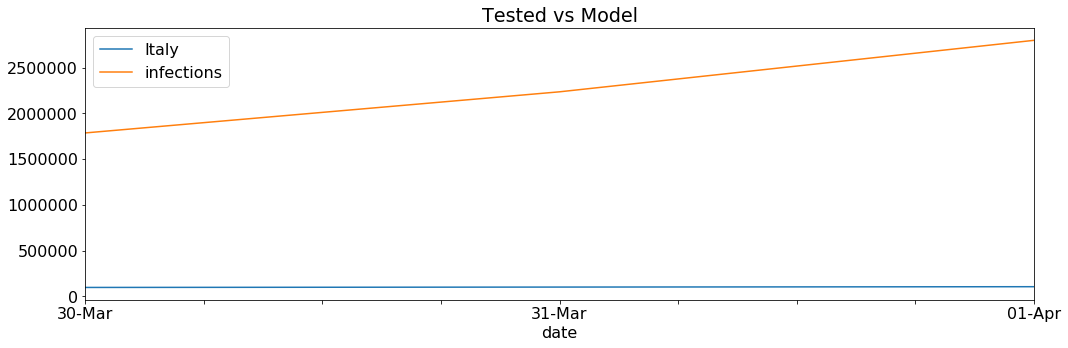

In [24]:
# plot 

#y = -0.67*0.17^x
dfitaly=data
dfitaly['model'] = 1.1562 + 0.2244*dfitaly['time']
dfitaly['infections'] = np.exp(dfitaly['model'])
dfitaly_plot = dfitaly.tail(3)
dfitaly_plot.plot(title='Tested vs Model' , x="date", y=["Italy", "infections"])
plt.savefig("pic7.png", dpi=150)
plt.show()

In [25]:
dfitaly_plot

,level_0,index,date,Italy,Italy_total,logInfections,time,model,infections
59,59,70,30-Mar,97689.0,610556.25,13.322126,59,14.3958,1.786555e+06
60,60,71,31-Mar,101739.0,635868.75,13.362747,60,14.6202,2.236002e+06
61,61,72,01-Apr,105792.0,661200.00,13.401812,61,14.8446,2.798516e+06


In [26]:
# dfUSA = dfanalisis[['date','USA']]
# dfUSA = dfUSA[dfUSA['USA'] > 0].reset_index()
# dfUSA.head()
# data = dfUSA
# data['logInfections']=np.log(data.USA)
# data['time'] = data.index
# data.head()
# X = data.time
# X=sm.add_constant(X)
# y= data.logInfections
# mod = sm.OLS(y,X)
# res = mod.fit()
# print(res.summary())
# # plot 

# #y = 4.7*0.27^x

# dfUSA['model'] = -0.8 + 0.16*dfUSA['time']
# dfUSA['infections'] = np.exp(dfUSA['model'])
# dfUSA.tail(5)
# dfUSA.plot(x="date", y=["USA", "infections"])
# plt.show()

In [27]:
dfSK = dfanalisis[['date','SK']]
dfSK = dfSK[dfSK['SK'] > 0].reset_index()
dfSK.head()

,index,date,SK
0,0,20-Jan,1
1,1,21-Jan,1
2,2,22-Jan,1
3,3,23-Jan,1
4,4,24-Jan,2


In [28]:
data = dfSK
data['SK_total'] = (data['SK']/.8)+ (data['SK']/.2)
data['logInfections']=np.log(data.SK_total)
data['time'] = data.index
data.head()

,index,date,SK,SK_total,logInfections,time
0,0,20-Jan,1,6.25,1.832581,0
1,1,21-Jan,1,6.25,1.832581,1
2,2,22-Jan,1,6.25,1.832581,2
3,3,23-Jan,1,6.25,1.832581,3
4,4,24-Jan,2,12.50,2.525729,4


In [29]:
X = data.time
X=sm.add_constant(X)
y= data.logInfections
mod = sm.OLS(y,X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          logInfections   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     763.4
Date:                Mon, 06 Apr 2020   Prob (F-statistic):           1.01e-39
Time:                        20:32:28   Log-Likelihood:                -99.640
No. Observations:                  73   AIC:                             203.3
Df Residuals:                      71   BIC:                             207.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3005      0.223     10.335      0.0

In [30]:
# plot 
data =dfSK
dfSK['model'] = 2.3005 + 0.1474*dfSK['time']
dfSK['infections'] = np.exp(dfSK['model'])
dfSK.rename(columns={'SK': 'SK tested'}, inplace=True)
dfSK_plot = dfSK.tail(20)

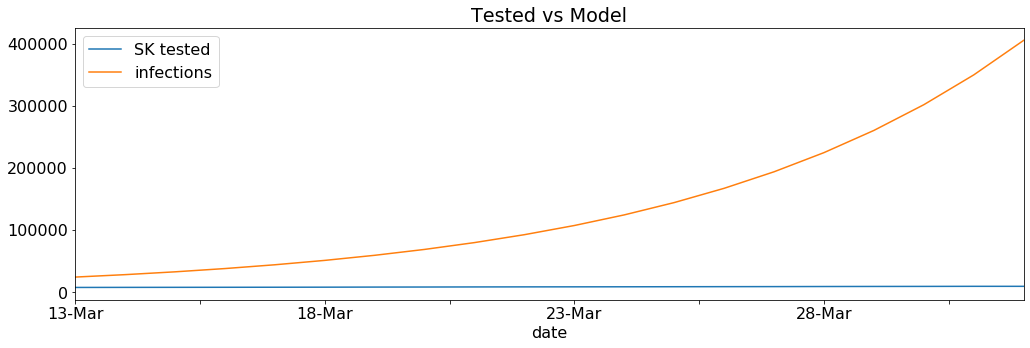

In [31]:
dfSK_plot.plot(title ='Tested vs Model' , x="date", y=["SK tested", "infections"])
plt.savefig("pic8.png", dpi=150)
plt.show()

In [32]:
dfSK_plot

,index,date,SK tested,SK_total,logInfections,time,model,infections
53,53,13-Mar,7979,49868.75,10.817150,53,10.1127,24654.137123
54,54,14-Mar,8086,50537.50,10.830471,54,10.2601,28569.643014
55,55,15-Mar,8162,51012.50,10.839826,55,10.4075,33106.999359
56,56,16-Mar,8236,51475.00,10.848852,56,10.5549,38364.966829
57,57,17-Mar,8320,52000.00,10.858999,57,10.7023,44457.991008
58,58,18-Mar,8413,52581.25,10.870115,58,10.8497,51518.693429
59,59,19-Mar,8565,53531.25,10.888021,59,10.9971,59700.758232
60,60,20-Mar,8652,54075.00,10.898127,60,11.1445,69182.277271
61,61,21-Mar,8799,54993.75,10.914975,61,11.2919,80169.626486
62,62,22-Mar,8897,55606.25,10.926051,62,11.4393,92901.957907


In [33]:
dfPo = dftotal_Portugal
dfPo = dfPo[dfPo['Portugal'] > 0].reset_index()
data = dfPo
data['Portugal_total'] = (data['Portugal']/.8)+ (data['Portugal']/.2)
data['logInfections']=np.log(data.Portugal_total)
data['time'] = data.index
data.tail()



,index,date,Portugal,Portugal_total,logInfections,time
30,93,2020-04-02,8251.0,51568.75,10.850671,30
31,94,2020-04-03,9034.0,56462.50,10.941332,31
32,95,2020-04-04,9886.0,61787.50,11.031456,32
33,96,2020-04-05,10524.0,65775.00,11.093995,33
34,97,2020-04-06,11278.0,70487.50,11.163191,34


In [34]:
X = data.time
X=sm.add_constant(X)
y= data.logInfections
mod = sm.OLS(y,X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          logInfections   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     894.1
Date:                Mon, 06 Apr 2020   Prob (F-statistic):           1.76e-25
Time:                        20:32:29   Log-Likelihood:                -24.646
No. Observations:                  35   AIC:                             53.29
Df Residuals:                      33   BIC:                             56.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6407      0.167     21.831      0.0

In [35]:
dfpo = data
dfPo['model'] = 3.4613 + 0.2690*dfPo['time']
dfPo['total-infected'] = np.exp(dfPo['model'])
dfPo.rename(columns={'Portugal': 'Portugal tested 20%'}, inplace=True)
dfPo_plot = dfPo.tail(10)
# Portugal total, show the base infections 20% tested and 80% not tested. 
#Total infected shows all population infected based on the modelling and not considering restrictions 

In [36]:
dfPo_plot

,index,date,Portugal tested 20%,Portugal_total,logInfections,time,model,total-infected
25,88,2020-03-28,4268.0,26675.00,10.191482,25,10.1863,26537.125664
26,89,2020-03-29,5170.0,32312.50,10.383209,26,10.4553,34727.945929
27,90,2020-03-30,5962.0,37262.50,10.525743,27,10.7243,45446.904978
28,91,2020-03-31,6408.0,40050.00,10.597884,28,10.9933,59474.325845
29,92,2020-04-01,7443.0,46518.75,10.747611,29,11.2623,77831.382277
30,93,2020-04-02,8251.0,51568.75,10.850671,30,11.5313,101854.438551
31,94,2020-04-03,9034.0,56462.50,10.941332,31,11.8003,133292.334648
32,95,2020-04-04,9886.0,61787.50,11.031456,32,12.0693,174433.699000
33,96,2020-04-05,10524.0,65775.00,11.093995,33,12.3383,228273.556968
34,97,2020-04-06,11278.0,70487.50,11.163191,34,12.6073,298731.363891


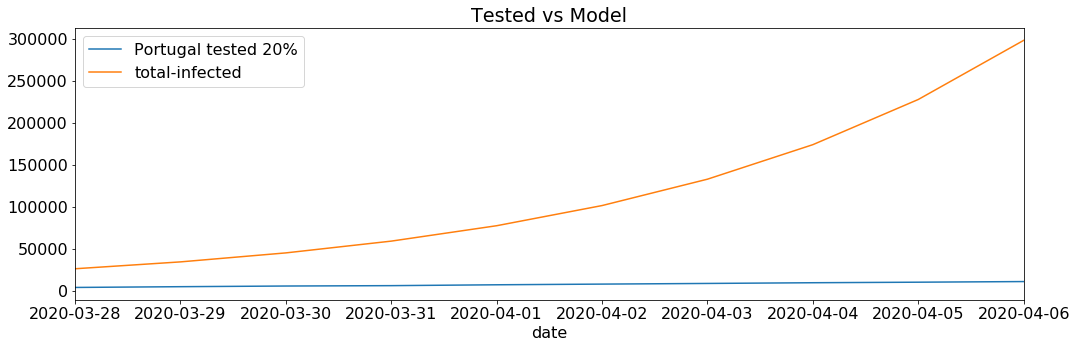

In [37]:
dfPo_plot.plot(title ='Tested vs Model', x="date", y=["Portugal tested 20%", "total-infected"])
plt.savefig("pic9.png", dpi=150)
plt.show()

In [38]:
#PPT AUTOMATION
from pptx import Presentation
from pptx.util import Inches, Pt
import os

def save_ppt(ppt, file_name):
	ppt.save(file_name)
	os.startfile(file_name)
    

def open_powerpoint(file_name):
	ppt = Presentation(file_name)
	return ppt

def create_slide(ppt, layout):
	return ppt.slides.add_slide(layout)

def add_blank_layout(ppt):
	ppt_layout = ppt.slide_layouts[6]
	current_slide = create_slide(ppt, ppt_layout)
	return current_slide

def slide_1 (ppt):
	ppt_layout = ppt.slide_layouts[6]
	slide_1 = add_slide(ppt, ppt_layout)
	return slide_1

def slide_2 (ppt):
	ppt_layout = ppt.slide_layouts[6]
	slide_2 = add_slide(ppt, ppt_layout)
	return slide_2

def slide_3 (ppt):
	ppt_layout = ppt.slide_layouts[6]
	slide_3 = add_slide(ppt, ppt_layout)
	return slide_3

def slide_4 (ppt):
	ppt_layout = ppt.slide_layouts[6]
	slide_4 = add_slide(ppt, ppt_layout)
	return slide_4

def slide_5 (ppt):
	ppt_layout = ppt.slide_layouts[6]
	slide_5 = add_slide(ppt, ppt_layout)
	return slide_5

def slide_6 (ppt):
	ppt_layout = ppt.slide_layouts[6]
	slide_6 = add_slide(ppt, ppt_layout)
	return slide_6


def add_text(slide, text, bold, font_size, pos_left, pos_right,pos_top):
	area_left = Inches(pos_left)
	area_right = Inches(pos_right)
	area_top = Inches(pos_top)
	area_height_width = Inches(1)
	text_area = slide.shapes.add_textbox(area_left, area_right, area_height_width, area_height_width)
	text_frame = text_area.text_frame

	current_paragraph = text_frame.add_paragraph()
	current_paragraph.text = text

	if bold == True:
		current_paragraph.font.bold = True

	current_paragraph.font.size = Pt(font_size)

def add_image(slide, image, pos_left, pos_top, width, *height):
	area_left = Inches(pos_left)
	area_top = Inches(pos_top)
	area_width = Inches(width)

	if len(height) > 0 :
		area_height = Inches(height[0])
		slide.shapes.add_picture(image, area_left, area_top, area_width, area_height)
	else:
		slide.shapes.add_picture(image, area_left, area_top, area_width)

file_name = "covid.pptx"
# create_powerpoint(file_name) to create a new file everytime or to use the same file 
ppt = open_powerpoint(file_name)

# add_basic_layouts(ppt)

current_slide = add_blank_layout(ppt)
add_text(current_slide, "IRONHACK DATA PROJECT 1", True, 45, 1, -0.3,0)
add_text(current_slide, "MODELLING COVID INFECTED VS TESTED PER COUNTRY", False, 20, 1, 1,0)
add_text(current_slide, "Basic tested graph on newspaper / What about “real infected”? ", False, 20, 1, 2,0)
add_image(current_slide, "pic0.png", 1, 3, 6)

slide_1 = add_blank_layout(ppt)
add_text(slide_1, "HOW? Data & Statistics", True, 45, 1, -0.3, 0)
add_text(slide_1, "DATA (3 APIs and 2 Datasets)", True, 20, 1, 1,0)
add_text(slide_1, "- 3 APIs (Global cases hourly, Cases country daily, Country updated hourly)", False, 20, 1, 1.5,0)
add_text(slide_1, "- 2 Datasets (Geodata, TMP)", False, 20, 1, 2,0)
add_image(slide_1, "folium.png", 4, 2.8, 2)
add_text(slide_1, "Statistics", True, 20, 1, 3.5,0)
add_text(slide_1, "Modelling with Log Transformation, Exponential Growth and Linear Regression", False, 20, 1, 4,0)
add_text(slide_1, " - Not considering recovered cases and restriction measures", False, 20, 1, 5,0)


slide_2 = add_blank_layout(ppt)
add_text(slide_2, "DATA, call variable global", True, 45, 1, -0.3, 0)
add_image(slide_2, "pic1.png", 1, 0.8, 7)
add_image(slide_2, "pic2.png", 1, 2.9, 7)
add_image(slide_2, "pic3.png", 1, 4.8, 7)



slide_3 = add_blank_layout(ppt)
add_text(slide_3, "Parameters TMP", True, 45, 1, -0.3, 0)
add_image(slide_3, "tmp-wid.png",1.3, 0.85, 3.5)
add_image(slide_3, "pic4.png", 1, 2.9, 8)
add_image(slide_3, "pic5.png", 1, 5, 8)



slide_4 = add_blank_layout(ppt)
add_text(slide_4, "MODELLING ", True, 45, 1, -0.3, 0)
add_text(slide_4, "– Log Transformation, Exponential Growth and Linear Regression)", True, 20, 1, 0.5,0)
add_text(slide_4, "Exponential Growth > math function (used by epidemic outbreaks)", False, 20, 1, 1.3,0)
add_text(slide_4, "Linear Regression > Growth Factor > formula log > linear regression)", False, 20, 1, 2,0)
add_image(slide_4, "piclog.png", 1, 3, 3.5)
add_image(slide_4, "pic6.png", 5, 3, 4.5)
add_image(slide_4, "model.png", 1, 6, 4.5)


slide_5 = add_blank_layout(ppt)
add_text(slide_5, "Outputs", True, 45, 1, -0.3, 0)
add_image(slide_5, "pic7.png", 1, 0.8, 7)
add_image(slide_5, "pic8.png", 1, 2.9, 7)
add_image(slide_5, "pic9.png", 1, 5, 7)


slide_6 = add_blank_layout(ppt)
add_text(slide_6, "THANK YOU", True, 45, 1, 3.5,0)

save_ppt(ppt, file_name)
